<h1>Task-3</h1>

<h4>Implement a support vector machine (SVM) to classify images of cats and dogs from the Kaggle dataset.a</h4>

Dataset: https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import zipfile
import os
zip_path = './train.zip'
extract_path = './train/'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    
dir_train = os.path.join(extract_path, 'train')

In [2]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report

In [3]:
image_files = [os.path.join(dir_train, file) for file in os.listdir(dir_train) if file.endswith('.jpg')]

In [4]:
imagefiles1 = image_files[:25000]

In [5]:
def compute_hog_features(image):
    image = rgb2gray(image)  
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   transform_sqrt=True)
    return features

In [6]:
def compute_hog_feature(image):
    
    gray_image = rgb2gray(image)
    
    
    features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2,2), block_norm='L2-Hys',
                              visualize=True, transform_sqrt=True)
    
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 20))
    
    return features, hog_image_rescaled

In [7]:
total_images = len(imagefiles1)
processed_images = 0

In [8]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

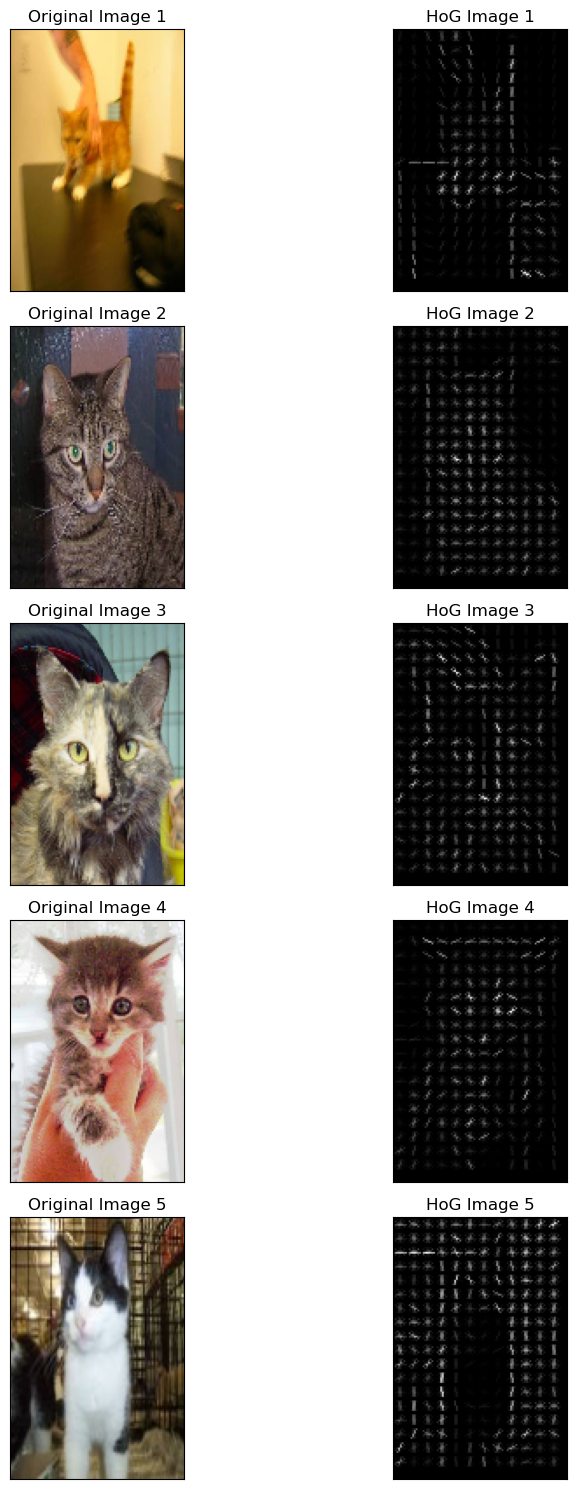

In [9]:
image_files = image_files[:5]

original_images = []
hog_images = []

for image_path in image_files:
    image = cv2.imread(image_path)  # Đọc hình ảnh bằng OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi sang định dạng RGB
    image = cv2.resize(image, (100,150))
    features, hog_image = compute_hog_feature(image)  # Tính toán các đặc trưng HoG
    original_images.append(image)
    hog_images.append(hog_image)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i in range(5):
    axes[i, 0].imshow(original_images[i])
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 1].imshow(hog_images[i], cmap='gray')
    axes[i, 1].set_title(f'HoG Image {i+1}')

plt.tight_layout()
plt.show()

In [10]:
hog_features_list = []
labels = []
for image_path in imagefiles1:
    processed_images += 1
    print(f"Processing image {processed_images}/{total_images}", end="\r")
    image = cv2.imread(image_path)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = cv2.resize(image, (100,150))
    features = compute_hog_features(image)  
    hog_features_list.append(features)
    
    if 'cat' in os.path.basename(image_path):
        labels.append(0)  # 0 cat
    elif 'dog' in os.path.basename(image_path):
        labels.append(1)  # 1 dog

In [11]:
X = np.array(hog_features_list)
y = np.array(labels)

In [12]:
X = np.array(hog_features_list)
y = np.array(labels)

In [13]:
print(X.shape)
print(y.shape)

(25000, 6732)
(25000,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

pca = PCA(n_components=100)  
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

In [16]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(max_iter=10000)
search_space = {
    'C': [0.1, 5, 10, 20]
}
GS = GridSearchCV(
    estimator=lr,  
    param_grid=search_space,  
)
GS.fit(X_train_pca, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.1, 5, 10, 20]})

In [17]:
best_params = GS.best_estimator_
best_params

LogisticRegression(C=5, max_iter=10000)

In [18]:
lo_r = LogisticRegression(C=0.1, max_iter=10000)
lo_r.fit(X_train_pca, y_train)
y_lo_r_pred = lo_r.predict(X_test_pca)
print(classification_report(y_test, y_lo_r_pred))

              precision    recall  f1-score   support

           0       0.72      0.67      0.70      2515
           1       0.69      0.74      0.71      2485

    accuracy                           0.70      5000
   macro avg       0.71      0.70      0.70      5000
weighted avg       0.71      0.70      0.70      5000



In [19]:
svm_1 = SVC(C=1, kernel='rbf')
svm_1.fit(X_train_pca, y_train)
y_pred = svm_1.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2515
           1       0.76      0.79      0.77      2485

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_pca)

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.80      0.46      0.59      2515
           1       0.62      0.88      0.73      2485

    accuracy                           0.67      5000
   macro avg       0.71      0.67      0.66      5000
weighted avg       0.71      0.67      0.66      5000



In [21]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1,100)),
    'weights': ['uniform'],
    'metric': ['euclidean']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_pca)

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.74      0.50      0.60      2515
           1       0.62      0.82      0.71      2485

    accuracy                           0.66      5000
   macro avg       0.68      0.66      0.66      5000
weighted avg       0.68      0.66      0.65      5000

